In [1]:
%autosave 30

Autosaving every 30 seconds


# Basics
* FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering.”
* It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.

## Import liberaries

In [44]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import load_model
from mtcnn.mtcnn import MTCNN

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

from platform import python_version
print(f"python version: {python_version()}")

python version: 3.7.12


## Import mctnn

In [46]:
import mtcnn
print(mtcnn.__version__)

0.1.0


## saved Model setup

In [45]:
## Get the general path for saved model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
model=load_model(path_saved_model+'facenet_keras.h5')

print(f"Input: {model.inputs}")
print(f"Output: {model.outputs}")

Input: [<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
Output: [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


# Dataset

## Download Kaggle dataset

In [47]:
sys.path.append(os.environ.get('DirForPoolScripts'))
from download_kaggle_data import upload_kaggle_dataset

In [48]:
base_dir = "/tmp/celebs"
dataset_name = 'dansbecker/5-celebrity-faces-dataset'
#upload_kaggle_dataset(base_dir_name=base_dir, kaggle_dataset_name=dataset_name)

# Data Preprocessing

## Extract face in given Shape

In [49]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

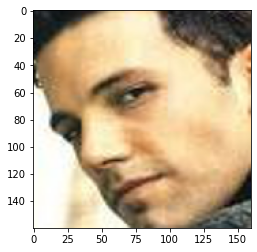

In [50]:
base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'
ben_dir  = base_dir + '/train/ben_afflek/'
madonna_dir  = base_dir + '/train/madonna/'

# load the photo and extract the face
pixels = extract_face(ben_dir+'httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)

In [ ]:
# specify folder to plot
i = 1
# enumerate files
for filename in os.listdir(ben_dir):
    path = ben_dir + filename
    face = extract_face(path)
    print(i, face.shape)
    plt.subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)


In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    for filename in os.listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [ ]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()

    for subdir in os.listdir(directory):
        path = directory + subdir + '/'
        
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
            
        faces = load_faces(path)
        
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        
        # store
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [ ]:
# load train dataset
trainX, trainy = load_dataset(base_dir+'train/')
testX, testy = load_dataset(base_dir+'/val/')
print(trainX.shape, trainy.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

## Face Embedding via Facenet

In [ ]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
model=load_model(path_saved_model+'facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

## Classifier

In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
# load dataset
data = np.load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

## Testing on test-images

In [ ]:
# load faces
data = np.load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# test model on a random example from the test dataset
selection          = random.choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb    = testX[selection]
random_face_class  = testy[selection]
random_face_name   = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples    = np.expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob  = model.predict_proba(samples)

# get name
class_index       = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names     = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()